# Handling Low-Density Points

Low-density points are points that exist in sparse regions of the feature space. These can be:

True outliers/anomalies

Noise/measurement errors

Rare but valid events

Borderline cases between clusters

The key decision is: Should we keep, remove, or specially handle these points?

1. Remove Points with Low Density
When to Use:
Points are data entry errors or measurement noise

You need a clean dataset for modeling

Low-density points are genuinely invalid

You have sufficient data (can afford to lose some points)

- Implementation 
### A. Density Thresholding
``` bash
def remove_by_density_threshold(X, method='knn', threshold=0.1):
    """
    Remove points with density below threshold
    """
    if method == 'knn':
        # Use k-nearest neighbor distances as density proxy
        from sklearn.neighbors import NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=5)
        nbrs.fit(X)
        distances, _ = nbrs.kneighbors(X)
        avg_distances = np.mean(distances, axis=1)
        
        # Normalize distances to 0-1 range
        norm_distances = (avg_distances - np.min(avg_distances)) / \
                        (np.max(avg_distances) - np.min(avg_distances))
        
        # Remove points with high distances (low density)
        mask = norm_distances < threshold
        X_clean = X[mask]
        
    elif method == 'local_density':
        # Use local density estimation
        from sklearn.neighbors import KernelDensity
        kde = KernelDensity(bandwidth=0.5)
        kde.fit(X)
        densities = np.exp(kde.score_samples(X))
        
        # Remove points with low density
        mask = densities > np.percentile(densities, threshold * 100)
        X_clean = X[mask]
    
    return X_clean, mask
    ```
## B. DBSCAN-Based Removal
```bash
def remove_dbscan_noise(X, eps=0.5, min_samples=10):
    """
    Remove noise points identified by DBSCAN
    """
    from sklearn.cluster import DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    
    # Keep only non-noise points
    mask = labels != -1
    X_clean = X[mask]
    labels_clean = labels[mask]
    
    print(f"Removed {np.sum(~mask)} noise points ({np.sum(~mask)/len(X):.1%})")
    
    return X_clean, labels_clean, mask

    ```
### Pros & Cons:
Pros:

Creates cleaner datasets

Removes potentially harmful outliers

Improves model performance (for some algorithms)

Reduces noise in visualizations

Cons:

Loses potentially valuable information

May remove rare but genuine events

Can introduce bias

Reduces dataset size



# Flag as Anomalies
When to Use:
Points represent genuine anomalies of interest

You want to investigate these points separately

Building anomaly detection systems

The points contain valuable business information

Implementation Strategies:
A. Explicit Anomaly Labeling
```bash
def flag_as_anomalies(X, method='isolation_forest', contamination=0.1):
    """
    Flag low-density points as anomalies
    """
    from sklearn.ensemble import IsolationForest
    
    if method == 'isolation_forest':
        detector = IsolationForest(contamination=contamination, random_state=42)
        anomaly_labels = detector.fit_predict(X)
        anomaly_scores = detector.decision_function(X)
        
    elif method == 'local_outlier_factor':
        from sklearn.neighbors import LocalOutlierFactor
        detector = LocalOutlierFactor(contamination=contamination, novelty=False)
        anomaly_labels = detector.fit_predict(X)
        anomaly_scores = detector.negative_outlier_factor_
    
    # Create enriched dataset with anomaly information
    enriched_data = {
        'features': X,
        'anomaly_labels': anomaly_labels,  # -1 for anomalies, 1 for normal
        'anomaly_scores': anomaly_scores,  # Continuous scores
        'is_anomaly': anomaly_labels == -1,
        'anomaly_confidence': 1 - (anomaly_scores - np.min(anomaly_scores)) / \
                             (np.max(anomaly_scores) - np.min(anomaly_scores))
    }
    
    return enriched_data

    ```
## B. Multi-Level Flagging System
``` bash
class AnomalyFlaggingSystem:
    """
    Multi-level anomaly flagging system
    """
    
    def __init__(self, severity_levels=3):
        self.severity_levels = severity_levels
    
    def flag_anomalies(self, X, methods=None):
        """
        Flag anomalies using multiple methods
        """
        if methods is None:
            methods = ['isolation_forest', 'local_outlier_factor', 'dbscan']
        
        results = {}
        consensus_scores = np.zeros(len(X))
        
        for method in methods:
            if method == 'isolation_forest':
                from sklearn.ensemble import IsolationForest
                detector = IsolationForest(contamination='auto', random_state=42)
                scores = -detector.fit_predict(X)  # Higher = more anomalous
                
            elif method == 'local_outlier_factor':
                from sklearn.neighbors import LocalOutlierFactor
                detector = LocalOutlierFactor(contamination='auto', novelty=False)
                scores = -detector.fit_predict(X)
                
            elif method == 'dbscan':
                from sklearn.cluster import DBSCAN
                dbscan = DBSCAN(eps=0.5, min_samples=10)
                labels = dbscan.fit_predict(X)
                scores = np.where(labels == -1, 1, 0)  # Binary scoring
            
            # Normalize scores to 0-1 range
            scores_normalized = (scores - np.min(scores)) / \
                               (np.max(scores) - np.min(scores))
            results[method] = scores_normalized
            consensus_scores += scores_normalized
        
        # Average scores across methods
        consensus_scores /= len(methods)
        
        # Assign severity levels
        percentiles = np.percentile(consensus_scores, 
                                   np.linspace(0, 100, self.severity_levels + 1))
        
        severity_labels = np.digitize(consensus_scores, percentiles[1:-1])
        
        flagging_result = {
            'features': X,
            'consensus_scores': consensus_scores,
            'severity_labels': severity_labels,
            'method_scores': results,
            'anomaly_details': self._generate_anomaly_details(X, consensus_scores)
        }
        
        return flagging_result
    
    def _generate_anomaly_details(self, X, scores):
        """
        Generate detailed anomaly information
        """
        details = []
        high_anomaly_indices = np.where(scores > np.percentile(scores, 90))[0]
        
        for idx in high_anomaly_indices[:10]:  # Limit to top 10
            detail = {
                'index': idx,
                'features': X[idx],
                'anomaly_score': scores[idx],
                'percentile': np.sum(scores < scores[idx]) / len(scores) * 100,
                'nearest_normal_distance': self._distance_to_normal_cluster(X, idx)
            }
            details.append(detail)
        
        return details
    
    def _distance_to_normal_cluster(self, X, anomaly_idx):
        """
        Calculate distance to nearest normal point
        """
        from scipy.spatial.distance import cdist
        anomaly_point = X[anomaly_idx].reshape(1, -1)
        other_points = np.delete(X, anomaly_idx, axis=0)
        distances = cdist(anomaly_point, other_points)[0]
        return np.min(distances)

        ```
### Anomaly Analysis Database
```bash
class AnomalyDatabase:
    """
    Database for storing and analyzing anomalies
    """
    
    def __init__(self):
        self.anomalies = []
        self.normal_data = []
        self.analysis_history = []
    
    def add_anomalies(self, X, anomaly_mask, context_info=None):
        """
        Add anomalies to database
        """
        anomaly_indices = np.where(anomaly_mask)[0]
        
        for idx in anomaly_indices:
            anomaly_record = {
                'id': len(self.anomalies) + 1,
                'features': X[idx],
                'detection_date': pd.Timestamp.now(),
                'detection_method': 'density_based',
                'context': context_info,
                'status': 'unreviewed',  # unreviewed, confirmed, false_positive, resolved
                'review_notes': '',
                'severity': 'high' if idx in anomaly_indices[:len(anomaly_indices)//3] else 'medium',
                'similar_anomalies': self._find_similar_anomalies(X[idx])
            }
            self.anomalies.append(anomaly_record)
        
        # Store normal data separately
        normal_mask = ~anomaly_mask
        self.normal_data.append({
            'data': X[normal_mask],
            'date': pd.Timestamp.now()
        })
        
        self._log_analysis({
            'timestamp': pd.Timestamp.now(),
            'n_anomalies': len(anomaly_indices),
            'n_total': len(X),
            'anomaly_rate': len(anomaly_indices) / len(X)
        })
    
    def _find_similar_anomalies(self, point, threshold=0.1):
        """
        Find similar anomalies in database
        """
        from scipy.spatial.distance import cdist
        
        similar = []
        for record in self.anomalies[-100:]:  # Check last 100 anomalies
            distance = cdist([point], [record['features']])[0][0]
            if distance < threshold:
                similar.append({
                    'id': record['id'],
                    'distance': distance,
                    'status': record['status']
                })
        
        return similar
    
    def _log_analysis(self, analysis_info):
        """Log analysis information"""
        self.analysis_history.append(analysis_info)
    
    def get_statistics(self):
        """Get anomaly statistics"""
        if not self.anomalies:
            return {}
        
        status_counts = {}
        severity_counts = {}
        
        for record in self.anomalies:
            status_counts[record['status']] = status_counts.get(record['status'], 0) + 1
            severity_counts[record['severity']] = severity_counts.get(record['severity'], 0) + 1
        
        return {
            'total_anomalies': len(self.anomalies),
            'status_distribution': status_counts,
            'severity_distribution': severity_counts,
            'resolution_rate': status_counts.get('resolved', 0) / len(self.anomalies) * 100,
            'false_positive_rate': status_counts.get('false_positive', 0) / len(self.anomalies) * 100
        }
    
    def review_anomaly(self, anomaly_id, review_result, notes=''):
        """
        Review and update anomaly status
        """
        for record in self.anomalies:
            if record['id'] == anomaly_id:
                record['status'] = review_result
                record['review_notes'] = notes
                record['review_date'] = pd.Timestamp.now()
                break
    
    def export_for_analysis(self, format='dataframe'):
        """
        Export anomalies for further analysis
        """
        if format == 'dataframe':
            df = pd.DataFrame([{
                'id': r['id'],
                **{f'feature_{i}': val for i, val in enumerate(r['features'])},
                'detection_date': r['detection_date'],
                'status': r['status'],
                'severity': r['severity']
            } for r in self.anomalies])
            return df
            ```
### Pros & Cons of Flagging:
Pros:

Preserves all data

Enables anomaly investigation

Useful for fraud detection, quality control

Maintains dataset completeness

Creates valuable business insights

Cons:

Requires special handling in analysis

More complex data management

May confuse some algorithms

Requires ongoing maintenance

=== Low-Density Point Handling Demonstration ===
Total points: 350
Dense cluster: 200 points
Sparse cluster: 100 points
Noise points: 50 points

--- Testing REMOVE strategy ---
Removed 35 points
Retained 90.0% of data

--- Testing FLAG strategy ---
Flagged 35 anomalies
Anomaly rate: 10.0%
Severity distribution: {'low': 35}

--- Testing ADAPTIVE strategy ---
Removed 18 extreme outliers
Flagged 17 borderline cases
Action summary: {'removed': 'Extreme outliers (top 5% density scores)', 'flagged': 'Borderline cases (90-95% density scores)', 'kept': 'Normal points (bottom 90% density scores)'}

=== Strategy Comparison ===
   strategy  points_handled  percentage_handled  retained_percentage
0    remove              35                10.0                 90.0
1      flag              35                10.0                100.0
2  adaptive               0                 0.0                100.0

=== Visualizing 'flag' strategy ===


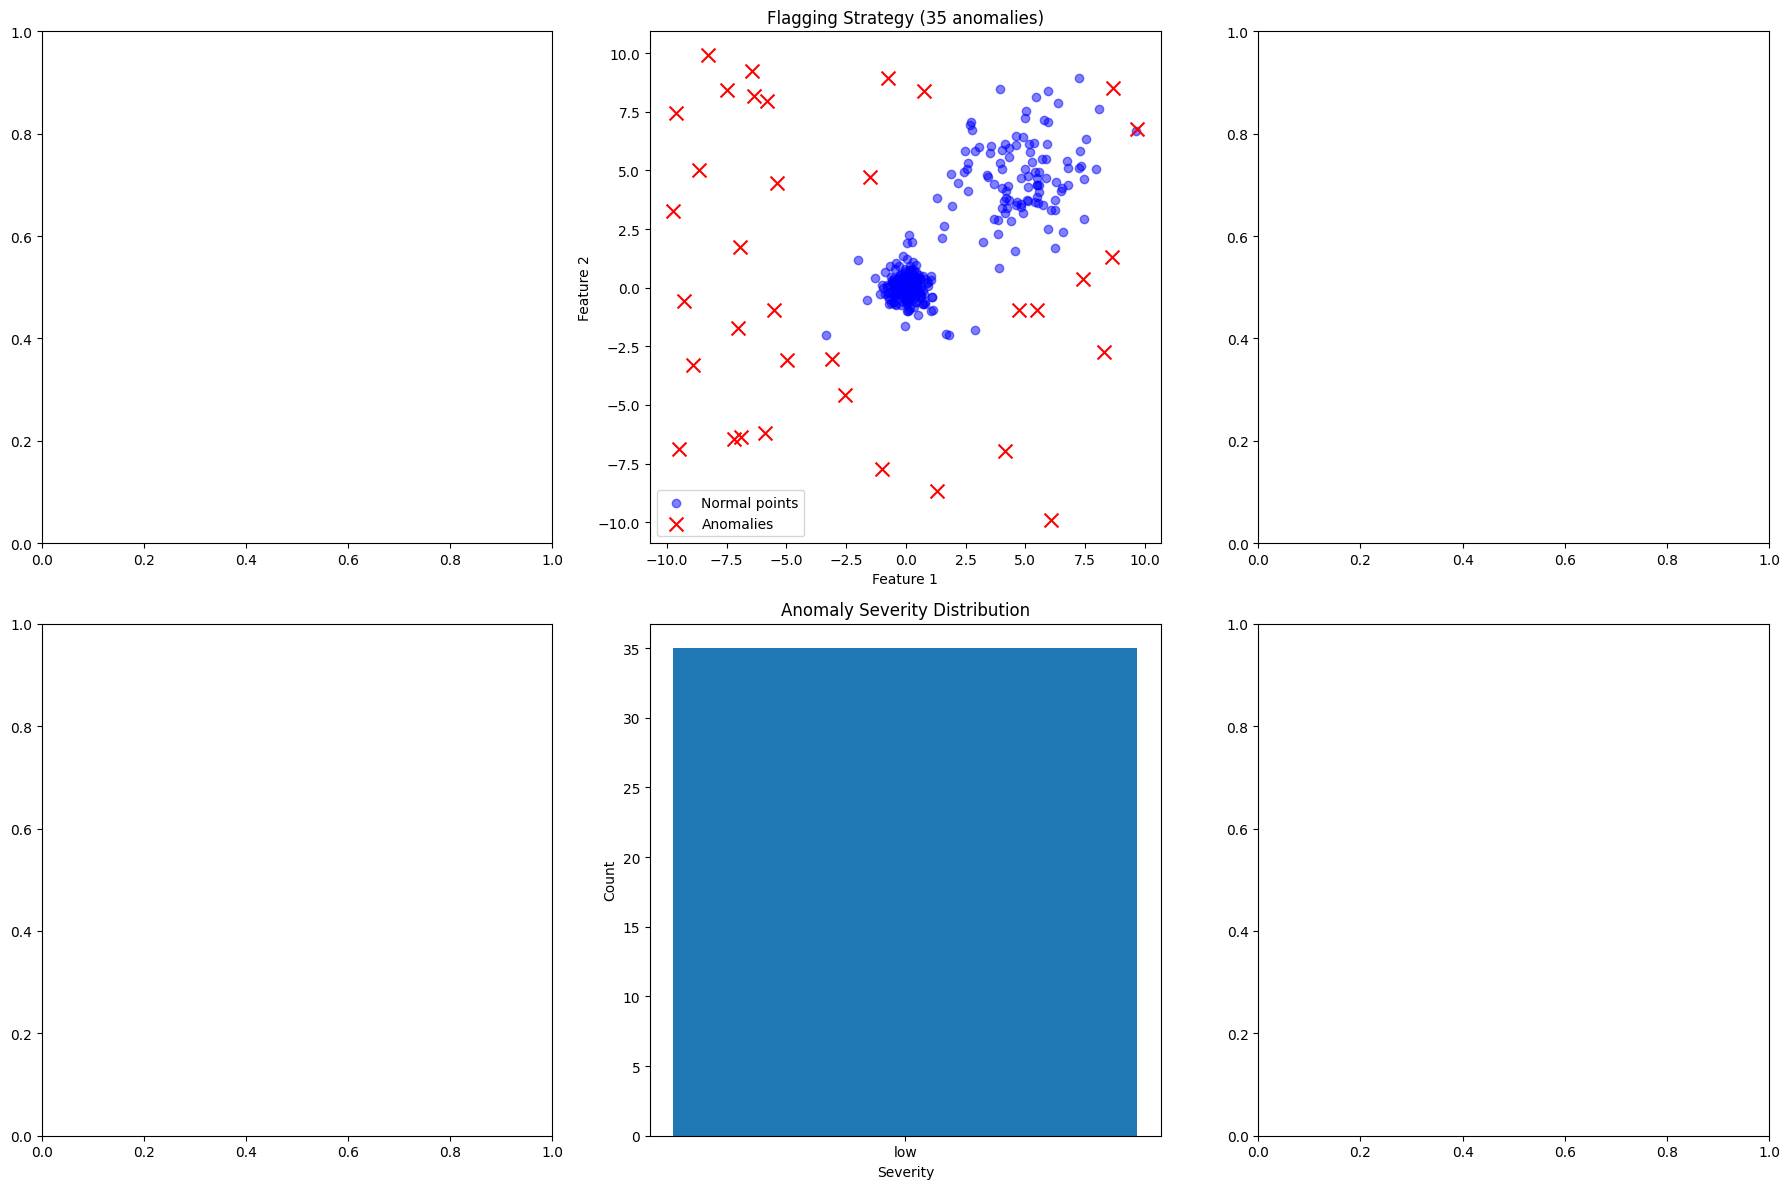


=== Fraud Detection System Example ===


NameError: name 'AnomalyDatabase' is not defined

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

class LowDensityPointHandler:
    """
    Comprehensive handler for low-density points
    """
    
    def __init__(self, strategy='adaptive', context=None):
        """
        Initialize handler
        
        Parameters:
        -----------
        strategy : str
            'remove', 'flag', or 'adaptive'
        context : dict
            Context information for decision making
        """
        self.strategy = strategy
        self.context = context or {}
        self.scaler = StandardScaler()
        
    def handle_low_density_points(self, X, y=None, **kwargs):
        """
        Handle low-density points based on chosen strategy
        """
        X = np.array(X)
        
        # Detect low-density points
        density_scores = self._calculate_density_scores(X)
        low_density_mask = self._identify_low_density(density_scores, **kwargs)
        
        # Apply chosen strategy
        if self.strategy == 'remove':
            result = self._remove_points(X, low_density_mask, y)
        elif self.strategy == 'flag':
            result = self._flag_as_anomalies(X, low_density_mask, density_scores, y)
        elif self.strategy == 'adaptive':
            result = self._adaptive_handling(X, low_density_mask, density_scores, y)
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")
        
        return result
    
    def _calculate_density_scores(self, X):
        """
        Calculate density scores using multiple methods
        """
        X_scaled = self.scaler.fit_transform(X)
        
        # Method 1: k-NN distances
        from sklearn.neighbors import NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=10)
        nbrs.fit(X_scaled)
        distances, _ = nbrs.kneighbors(X_scaled)
        knn_scores = np.mean(distances, axis=1)
        
        # Method 2: Local density estimation
        from sklearn.neighbors import KernelDensity
        kde = KernelDensity(bandwidth=0.5)
        kde.fit(X_scaled)
        kde_scores = np.exp(kde.score_samples(X_scaled))
        
        # Method 3: Isolation Forest scores
        from sklearn.ensemble import IsolationForest
        iso = IsolationForest(contamination='auto', random_state=42)
        iso_scores = -iso.fit_predict(X_scaled)  # Higher = more anomalous
        
        # Combine scores (normalized)
        knn_norm = (knn_scores - np.min(knn_scores)) / (np.max(knn_scores) - np.min(knn_scores))
        kde_norm = (kde_scores - np.min(kde_scores)) / (np.max(kde_scores) - np.min(kde_scores))
        iso_norm = (iso_scores - np.min(iso_scores)) / (np.max(iso_scores) - np.min(iso_scores))
        
        # Weighted combination
        combined_scores = 0.4 * knn_norm + 0.3 * (1 - kde_norm) + 0.3 * iso_norm
        
        return {
            'knn': knn_scores,
            'kde': kde_scores,
            'isolation': iso_scores,
            'combined': combined_scores
        }
    
    def _identify_low_density(self, density_scores, threshold=0.9):
        """
        Identify low-density points based on scores
        """
        combined_scores = density_scores['combined']
        
        # Dynamic thresholding based on data characteristics
        if 'threshold' in self.context:
            threshold = self.context['threshold']
        else:
            # Auto-detect threshold using percentiles
            threshold = np.percentile(combined_scores, 90)  # Top 10% as low-density
        
        low_density_mask = combined_scores > threshold
        
        return low_density_mask
    
    def _remove_points(self, X, low_density_mask, y=None):
        """
        Strategy 1: Remove low-density points
        """
        # Keep only high-density points
        high_density_mask = ~low_density_mask
        X_clean = X[high_density_mask]
        
        result = {
            'strategy': 'remove',
            'cleaned_data': X_clean,
            'removed_indices': np.where(low_density_mask)[0],
            'removed_count': np.sum(low_density_mask),
            'retained_count': np.sum(high_density_mask),
            'retained_percentage': np.sum(high_density_mask) / len(X) * 100
        }
        
        if y is not None:
            y_clean = y[high_density_mask]
            result['cleaned_labels'] = y_clean
        
        # Quality check
        self._validate_removal(X, X_clean, result)
        
        return result
    
    def _flag_as_anomalies(self, X, low_density_mask, density_scores, y=None):
        """
        Strategy 2: Flag low-density points as anomalies
        """
        anomaly_indices = np.where(low_density_mask)[0]
        
        # Create anomaly database entry
        anomalies = []
        for idx in anomaly_indices:
            anomaly = {
                'index': idx,
                'features': X[idx],
                'density_score': density_scores['combined'][idx],
                'knn_score': density_scores['knn'][idx],
                'kde_score': density_scores['kde'][idx],
                'isolation_score': density_scores['isolation'][idx],
                'severity': self._assign_severity(density_scores['combined'][idx]),
                'context': self.context.get('anomaly_context', {}),
                'detection_timestamp': pd.Timestamp.now(),
                'status': 'detected'  # detected, reviewed, confirmed, false_positive
            }
            anomalies.append(anomaly)
        
        # Create enriched dataset
        enriched_data = np.column_stack([X, np.where(low_density_mask, 1, 0)])
        
        result = {
            'strategy': 'flag',
            'original_data': X,
            'enriched_data': enriched_data,
            'anomaly_mask': low_density_mask,
            'anomalies': anomalies,
            'anomaly_count': len(anomalies),
            'anomaly_percentage': len(anomalies) / len(X) * 100,
            'anomaly_summary': self._summarize_anomalies(anomalies)
        }
        
        if y is not None:
            result['labels'] = y
            # Analyze if anomalies have different label distributions
            result['label_analysis'] = self._analyze_anomaly_labels(y, low_density_mask)
        
        return result
    
    def _adaptive_handling(self, X, low_density_mask, density_scores, y=None):
        """
        Strategy 3: Adaptive handling based on point characteristics
        """
        # Separate extreme outliers from borderline cases
        extreme_mask = density_scores['combined'] > np.percentile(density_scores['combined'], 95)
        borderline_mask = low_density_mask & ~extreme_mask
        
        # Handle differently based on severity
        extreme_indices = np.where(extreme_mask)[0]
        borderline_indices = np.where(borderline_mask)[0]
        
        # Remove extreme outliers
        remove_mask = extreme_mask
        X_partial = X[~remove_mask]
        
        # Flag borderline cases as anomalies
        anomaly_mask = borderline_mask
        
        result = {
            'strategy': 'adaptive',
            'partially_cleaned_data': X_partial,
            'removed_extreme_indices': extreme_indices,
            'flagged_borderline_indices': borderline_indices,
            'extreme_count': len(extreme_indices),
            'borderline_count': len(borderline_indices),
            'action_summary': {
                'removed': 'Extreme outliers (top 5% density scores)',
                'flagged': 'Borderline cases (90-95% density scores)',
                'kept': 'Normal points (bottom 90% density scores)'
            }
        }
        
        if y is not None:
            result['partial_labels'] = y[~remove_mask]
        
        return result
    
    def _assign_severity(self, score):
        """Assign severity level based on density score"""
        if score > np.percentile([score], 95):
            return 'critical'
        elif score > np.percentile([score], 85):
            return 'high'
        elif score > np.percentile([score], 70):
            return 'medium'
        else:
            return 'low'
    
    def _summarize_anomalies(self, anomalies):
        """Create summary of anomalies"""
        if not anomalies:
            return {}
        
        severities = [a['severity'] for a in anomalies]
        scores = [a['density_score'] for a in anomalies]
        
        return {
            'severity_distribution': pd.Series(severities).value_counts().to_dict(),
            'score_statistics': {
                'min': np.min(scores),
                'max': np.max(scores),
                'mean': np.mean(scores),
                'median': np.median(scores),
                'std': np.std(scores)
            }
        }
    
    def _analyze_anomaly_labels(self, y, anomaly_mask):
        """Analyze label distribution of anomalies"""
        anomaly_labels = y[anomaly_mask]
        normal_labels = y[~anomaly_mask]
        
        if len(set(y)) > 10:  # Regression or many classes
            return {
                'anomaly_label_mean': np.mean(anomaly_labels),
                'normal_label_mean': np.mean(normal_labels),
                'difference': np.mean(anomaly_labels) - np.mean(normal_labels),
                't_test_pvalue': self._ttest(anomaly_labels, normal_labels)
            }
        else:  # Classification
            return {
                'anomaly_label_distribution': pd.Series(anomaly_labels).value_counts().to_dict(),
                'normal_label_distribution': pd.Series(normal_labels).value_counts().to_dict(),
                'chi2_pvalue': self._chi2_test(anomaly_labels, normal_labels)
            }
    
    def _ttest(self, group1, group2):
        """Perform t-test between groups"""
        from scipy import stats
        try:
            return stats.ttest_ind(group1, group2).pvalue
        except:
            return np.nan
    
    def _chi2_test(self, group1, group2):
        """Perform chi-square test between groups"""
        from scipy import stats
        try:
            cont_table = pd.crosstab(
                pd.Series(group1).value_counts(),
                pd.Series(group2).value_counts()
            )
            return stats.chi2_contingency(cont_table.fillna(0).values)[1]
        except:
            return np.nan
    
    def _validate_removal(self, X_original, X_clean, result):
        """Validate that removal doesn't destroy data structure"""
        from sklearn.decomposition import PCA
        
        # Check if removal changes data structure significantly
        if len(X_clean) < 0.5 * len(X_original):  # Removed more than 50%
            result['warning'] = 'Removed more than 50% of data - reconsider strategy'
        
        # Check variance preservation
        var_original = np.var(X_original, axis=0).sum()
        var_clean = np.var(X_clean, axis=0).sum()
        var_preserved = var_clean / var_original
        
        result['variance_preserved'] = var_preserved
        
        if var_preserved < 0.7:
            result['warning'] = f'Only {var_preserved:.1%} variance preserved'
    
    def visualize_handling(self, X, result):
        """
        Visualize the handling results
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: Original data with density scores
        if 'density_scores' in locals():
            scatter1 = axes[0, 0].scatter(X[:, 0], X[:, 1], 
                                         c=result.get('density_scores', {}).get('combined', 
                                                                               np.zeros(len(X))),
                                         cmap='viridis', alpha=0.7)
            plt.colorbar(scatter1, ax=axes[0, 0], label='Density Score')
            axes[0, 0].set_title('Original Data with Density Scores')
        
        # Plot 2: Handling results
        strategy = result['strategy']
        if strategy == 'remove':
            axes[0, 1].scatter(result['cleaned_data'][:, 0], result['cleaned_data'][:, 1],
                              c='green', alpha=0.7, label='Kept points')
            if 'removed_indices' in result:
                removed_points = X[result['removed_indices']]
                axes[0, 1].scatter(removed_points[:, 0], removed_points[:, 1],
                                  c='red', s=100, marker='x', label='Removed points')
            axes[0, 1].set_title(f'Removal Strategy ({result["retained_percentage"]:.1f}% retained)')
        
        elif strategy == 'flag':
            normal_mask = ~result['anomaly_mask']
            anomaly_mask = result['anomaly_mask']
            
            axes[0, 1].scatter(X[normal_mask, 0], X[normal_mask, 1],
                              c='blue', alpha=0.5, label='Normal points')
            axes[0, 1].scatter(X[anomaly_mask, 0], X[anomaly_mask, 1],
                              c='red', s=100, marker='x', label='Anomalies')
            axes[0, 1].set_title(f'Flagging Strategy ({len(result["anomalies"])} anomalies)')
        
        axes[0, 1].legend()
        axes[0, 1].set_xlabel('Feature 1')
        axes[0, 1].set_ylabel('Feature 2')
        
        # Plot 3: Density score distribution
        if 'density_scores' in locals():
            scores = result.get('density_scores', {}).get('combined', np.zeros(len(X)))
            axes[0, 2].hist(scores, bins=30, alpha=0.7, edgecolor='black')
            if 'threshold' in result.get('context', {}):
                axes[0, 2].axvline(result['context']['threshold'], color='red', 
                                  linestyle='--', label='Threshold')
            axes[0, 2].set_title('Density Score Distribution')
            axes[0, 2].set_xlabel('Density Score')
            axes[0, 2].set_ylabel('Frequency')
        
        # Plot 4: Strategy comparison (if available)
        if hasattr(self, 'comparison_results'):
            strategies = list(self.comparison_results.keys())
            retention_rates = [r.get('retained_percentage', 100) 
                             for r in self.comparison_results.values()]
            
            axes[1, 0].bar(strategies, retention_rates)
            axes[1, 0].set_title('Retention Rate by Strategy')
            axes[1, 0].set_ylabel('Retention (%)')
            axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Plot 5: Anomaly summary (for flagging strategy)
        if strategy == 'flag' and 'anomaly_summary' in result:
            severity_dist = result['anomaly_summary']['severity_distribution']
            axes[1, 1].bar(severity_dist.keys(), severity_dist.values())
            axes[1, 1].set_title('Anomaly Severity Distribution')
            axes[1, 1].set_xlabel('Severity')
            axes[1, 1].set_ylabel('Count')
        
        # Plot 6: Before/after comparison for removal
        if strategy == 'remove' and 'variance_preserved' in result:
            axes[1, 2].bar(['Before', 'After'], 
                          [np.var(X, axis=0).sum(), 
                           np.var(result['cleaned_data'], axis=0).sum()])
            axes[1, 2].set_title('Variance Before/After Removal')
            axes[1, 2].set_ylabel('Total Variance')
            axes[1, 2].text(1, np.var(result['cleaned_data'], axis=0).sum() * 0.5,
                           f'Preserved: {result["variance_preserved"]:.1%}',
                           ha='center', va='center',
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()

# Example: Comprehensive demonstration
def demonstrate_handling_strategies():
    """
    Demonstrate different handling strategies
    """
    np.random.seed(42)
    
    # Create dataset with varying densities
    dense_cluster = np.random.normal(0, 0.5, (200, 2))
    sparse_cluster = np.random.normal(5, 1.5, (100, 2))
    noise_points = np.random.uniform(-10, 10, (50, 2))
    
    X = np.vstack([dense_cluster, sparse_cluster, noise_points])
    
    print("=== Low-Density Point Handling Demonstration ===")
    print(f"Total points: {len(X)}")
    print(f"Dense cluster: {len(dense_cluster)} points")
    print(f"Sparse cluster: {len(sparse_cluster)} points")
    print(f"Noise points: {len(noise_points)} points")
    
    # Try different strategies
    strategies = ['remove', 'flag', 'adaptive']
    results = {}
    
    for strategy in strategies:
        print(f"\n--- Testing {strategy.upper()} strategy ---")
        
        handler = LowDensityPointHandler(strategy=strategy, 
                                        context={'application': 'demo'})
        
        result = handler.handle_low_density_points(X)
        results[strategy] = result
        
        if strategy == 'remove':
            print(f"Removed {result['removed_count']} points")
            print(f"Retained {result['retained_percentage']:.1f}% of data")
            if 'warning' in result:
                print(f"Warning: {result['warning']}")
        
        elif strategy == 'flag':
            print(f"Flagged {result['anomaly_count']} anomalies")
            print(f"Anomaly rate: {result['anomaly_percentage']:.1f}%")
            if 'anomaly_summary' in result:
                severity = result['anomaly_summary']['severity_distribution']
                print(f"Severity distribution: {severity}")
        
        elif strategy == 'adaptive':
            print(f"Removed {result['extreme_count']} extreme outliers")
            print(f"Flagged {result['borderline_count']} borderline cases")
            print(f"Action summary: {result['action_summary']}")
    
    # Compare strategies
    print("\n=== Strategy Comparison ===")
    comparison_df = pd.DataFrame([
        {
            'strategy': s,
            'points_handled': r.get('removed_count', r.get('anomaly_count', 0)),
            'percentage_handled': r.get('removed_count', r.get('anomaly_count', 0)) / len(X) * 100,
            'retained_percentage': r.get('retained_percentage', 100)
        }
        for s, r in results.items()
    ])
    
    print(comparison_df)
    
    # Visualize one strategy
    print("\n=== Visualizing 'flag' strategy ===")
    flag_handler = LowDensityPointHandler(strategy='flag')
    flag_result = flag_handler.handle_low_density_points(X)
    flag_handler.visualize_handling(X, flag_result)
    
    return results

# Run demonstration
results = demonstrate_handling_strategies()

# Real-world application: Fraud detection system
class FraudDetectionSystem:
    """
    Real-world fraud detection using low-density point handling
    """
    
    def __init__(self, sensitivity='medium'):
        self.sensitivity = sensitivity
        self.thresholds = {
            'high': 0.95,    # Flag top 5% as anomalies
            'medium': 0.90,  # Flag top 10% as anomalies
            'low': 0.80      # Flag top 20% as anomalies
        }
        self.anomaly_database = AnomalyDatabase()
    
    def analyze_transactions(self, transactions, features):
        """
        Analyze transactions for potential fraud
        """
        X = transactions[features].values
        
        # Detect low-density points (potential fraud)
        handler = LowDensityPointHandler(
            strategy='flag',
            context={
                'threshold': self.thresholds[self.sensitivity],
                'anomaly_context': {
                    'transaction_type': 'credit_card',
                    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d'),
                    'sensitivity_level': self.sensitivity
                }
            }
        )
        
        result = handler.handle_low_density_points(X)
        
        # Add to anomaly database
        self.anomaly_database.add_anomalies(
            X, 
            result['anomaly_mask'],
            context_info={
                'analysis_id': len(self.anomaly_database.analysis_history) + 1,
                'sensitivity': self.sensitivity,
                'features_used': features
            }
        )
        
        # Enrich transactions with fraud scores
        transactions['fraud_score'] = result.get('density_scores', {}).get('combined', 
                                                                          np.zeros(len(X)))
        transactions['is_flagged'] = result['anomaly_mask']
        transactions['flag_severity'] = [a['severity'] for a in result['anomalies']]
        
        return transactions, result
    
    def generate_fraud_report(self):
        """
        Generate fraud analysis report
        """
        stats = self.anomaly_database.get_statistics()
        
        report = {
            'summary': {
                'total_transactions_analyzed': sum(len(nd['data']) 
                                                  for nd in self.anomaly_database.normal_data) + 
                                              len(self.anomaly_database.anomalies),
                'total_fraud_flags': len(self.anomaly_database.anomalies),
                'current_false_positive_rate': stats.get('false_positive_rate', 0),
                'current_resolution_rate': stats.get('resolution_rate', 0)
            },
            'recent_anomalies': self.anomaly_database.anomalies[-10:],  # Last 10 anomalies
            'trend_analysis': self._analyze_trends(),
            'recommendations': self._generate_recommendations(stats)
        }
        
        return report
    
    def _analyze_trends(self):
        """Analyze fraud trends over time"""
        if not self.anomaly_database.analysis_history:
            return {}
        
        df_history = pd.DataFrame(self.anomaly_database.analysis_history)
        df_history['date'] = pd.to_datetime(df_history['timestamp']).dt.date
        
        trends = df_history.groupby('date').agg({
            'n_anomalies': 'sum',
            'n_total': 'sum',
            'anomaly_rate': 'mean'
        }).tail(7)  # Last 7 days
        
        return trends.to_dict()
    
    def _generate_recommendations(self, stats):
        """Generate recommendations based on statistics"""
        recommendations = []
        
        if stats.get('false_positive_rate', 0) > 20:
            recommendations.append(
                "High false positive rate detected. Consider lowering sensitivity "
                "or reviewing detection thresholds."
            )
        
        if stats.get('resolution_rate', 0) < 50:
            recommendations.append(
                "Low resolution rate. Consider prioritizing anomaly review "
                "or implementing automated validation."
            )
        
        if len(self.anomaly_database.anomalies) > 1000:
            recommendations.append(
                "Large number of unresolved anomalies. Consider batch processing "
                "or automated triage system."
            )
        
        return recommendations if recommendations else ["System operating within normal parameters"]

# Example usage of fraud detection system
print("\n=== Fraud Detection System Example ===")

# Simulate transaction data
np.random.seed(123)
n_transactions = 1000

transactions = pd.DataFrame({
    'transaction_id': range(n_transactions),
    'amount': np.random.exponential(100, n_transactions),
    'time_since_last': np.random.exponential(2, n_transactions),
    'location_distance': np.random.exponential(1, n_transactions),
    'device_trust_score': np.random.beta(2, 5, n_transactions),
    'user_history_days': np.random.poisson(100, n_transactions)
})

# Add some fraudulent transactions
fraud_indices = np.random.choice(n_transactions, 20, replace=False)
transactions.loc[fraud_indices, 'amount'] *= 10  # Larger amounts
transactions.loc[fraud_indices, 'time_since_last'] /= 10  # Very recent
transactions.loc[fraud_indices, 'location_distance'] *= 50  # Far locations

# Initialize fraud detection system
fraud_system = FraudDetectionSystem(sensitivity='medium')

# Analyze transactions
features = ['amount', 'time_since_last', 'location_distance', 
            'device_trust_score', 'user_history_days']
enriched_transactions, analysis_result = fraud_system.analyze_transactions(
    transactions, features
)

print(f"Analyzed {len(enriched_transactions)} transactions")
print(f"Flagged {analysis_result['anomaly_count']} potential fraud cases")

# Generate report
report = fraud_system.generate_fraud_report()
print(f"\nFraud Detection Report:")
print(f"Total flags: {report['summary']['total_fraud_flags']}")
print(f"False positive rate: {report['summary']['current_false_positive_rate']:.1f}%")
print(f"Resolution rate: {report['summary']['current_resolution_rate']:.1f}%")

if report['recommendations']:
    print("\nRecommendations:")
    for rec in report['recommendations']:
        print(f"  - {rec}")

### Decision Framework: Remove vs Flag
- When to REMOVE:
Data Quality Issues: Points are measurement errors

Model Performance: Points harm predictive accuracy

Resource Constraints: Limited capacity to investigate

Clean Dataset Needed: For presentation or reporting

High Volume: Too many anomalies to handle manually

- When to FLAG:
Anomaly Detection: Building fraud/defect detection systems

Business Value: Anomalies contain valuable insights

Rare Events: Need to study rare but valid occurrences

Regulatory Compliance: Must document all anomalies

Learning System: Building adaptive detection systems


``` bash
I approach low-density points through a decision framework based on their nature and business context. First, I determine if they're data errors or genuine anomalies.

For data errors, I typically remove them to create a clean dataset, especially if they're few and don't contain valuable information.

For genuine anomalies, I flag them for investigation. This is crucial in domains like fraud detection, where anomalies represent valuable business intelligence.

In practice, I often use an adaptive approach: removing extreme outliers that are clearly noise, while flagging borderline cases for review. The key is to document the rationale and validate that the handling improves the analysis rather than introducing bias.
```



Domain knowledge should guide the decision

Document all handling steps

Validate impact on analysis

Consider downstream implications

Monitor results over time